## 각종 필요 패키지 import

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

## CSV 파일 line 수를 저장하는 클래스 정의

In [2]:
class DLQC():
    def __init__(self, years):
        self.years = years
        for year in years:
            setattr(self, f'min_{year}', defaultdict(lambda: np.zeros(shape=12)))
            setattr(self, f'qcd_{year}', defaultdict(lambda: np.zeros(shape=12)))

# dlqc.min_2021[stn_id][0:12] = lines

## csv line 세는 함수 정의

In [3]:
def get_lines_with_csv_path(path):
    chunk = 1024*1024   # Process 1 MB at a time.
    f = np.memmap(path, mode='r')
    num_newlines = sum(np.sum(f[i:i+chunk] == ord('\n')) for i in range(0, len(f), chunk))
    del f
    return num_newlines

In [4]:
data_dir = 'CSV3DB'
header_name = ['time', 'ta', 'wd', 'ws', 'rn', 'pa', 're', 'sd', 'hm']
dtype_dict = {
    'ta': np.float32,
    'wd': np.float32,
    'ws': np.float32,
    'rn': np.float32,
    'pa': np.float32,
    're': np.float32,
    'sd': np.float32,
    'hm': np.float32
    }
years = list(map(int, filter(lambda x: not x.endswith('pickle'), os.listdir(data_dir)))) # [2021, 2022]

dlqc = DLQC(years)

## 간단한 비교

먼저 모든 csv 파일을 다 읽진 않고 줄바꿈 수만 읽어서 line 수만 저장해놓는다.

In [5]:
for year in years:
    year = str(year)
    pbar = tqdm(os.listdir(os.path.join('CSV3DB', year)), desc=year)
    for csv_name in pbar:
        if csv_name.endswith('csv'):
            _, _, m_q, stn_id, date = csv_name.split('_')
            stn_id = int(stn_id)
            date, _ = date.split('.')
            date = int(date)
            getattr(dlqc, f'{m_q}_{year}')[stn_id][date % 100 - 1] = get_lines_with_csv_path(os.path.join('CSV3DB', year, csv_name))


2022: 100%|██████████| 16330/16330 [00:38<00:00, 422.27it/s]


In [6]:
# station id가 몇 개인지 확인
len(dlqc.min_2021), len(dlqc.qcd_2021), len(dlqc.min_2022), len(dlqc.qcd_2022)

(761, 761, 754, 753)

2021년과 2022년의 stn_id 개수가 서로 맞지 않는다.

또, 2022년의 min과 qcd의 stn_id 개수가 같지 않다.

먼저 2021년 min, qcd간의 stn_id와 2022년 min, qcd간의 stn_id가 서로 같은지 확인한다.

In [7]:
# 2021년은 같지만 2022년은 다르다.
set(dlqc.min_2021) == set(dlqc.qcd_2021), set(dlqc.min_2022) == set(dlqc.qcd_2022)

(True, False)

In [8]:
set(dlqc.min_2022) - set(dlqc.qcd_2022), set(dlqc.qcd_2022) - set(dlqc.min_2022)

({111}, set())

2022년 111번은 min은 있지만 qcd가 없다.

2022년 111번 min csv 이름 찾기

In [9]:
no_qcd_list = list(filter(lambda x: x.startswith('dlqc_aws3_min_111'), os.listdir(os.path.join(data_dir, '2022'))))
no_qcd_list

['dlqc_aws3_min_111_202207.csv']

In [10]:
# 하나의 csv파일이므로 열어서 확인
bad_df = pd.read_csv(os.path.join(data_dir, '2022', no_qcd_list[0]),
                      names=header_name)
bad_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.0,56.000000
mean,30.235714,185.366071,1.091071,0.0,-999.0,-999.0,-999.0,-661.232143
std,1.508452,144.805072,0.524760,0.0,0.0,0.0,0.0,495.211286
min,26.600000,0.000000,0.100000,0.0,-999.0,-999.0,-999.0,-999.000000
25%,29.650000,39.550000,0.700000,0.0,-999.0,-999.0,-999.0,-999.000000
50%,30.500000,190.050000,1.100000,0.0,-999.0,-999.0,-999.0,-999.000000
75%,31.500000,326.125000,1.300000,0.0,-999.0,-999.0,-999.0,48.000000
max,32.800000,359.800000,2.400000,0.0,-999.0,-999.0,-999.0,58.000000


In [11]:
bad_df.head(10)

,time,ta,wd,ws,rn,pa,re,sd,hm
0,2022.07.11 15:53:00,28.3,315.9,2.0,0.0,-999.0,-999,-999.0,-999
1,2022.07.11 15:54:00,28.3,285.4,2.1,0.0,-999.0,-999,-999.0,-999
2,2022.07.11 15:55:00,28.2,209.4,1.3,0.0,-999.0,-999,-999.0,-999
3,2022.07.11 15:57:00,28.2,348.5,1.0,0.0,-999.0,-999,-999.0,-999
4,2022.07.11 16:10:00,27.9,317.7,1.5,0.0,-999.0,-999,-999.0,-999
5,2022.07.11 16:11:00,27.9,335.1,2.4,0.0,-999.0,-999,-999.0,-999
6,2022.07.11 16:12:00,27.9,318.5,2.2,0.0,-999.0,-999,-999.0,-999
7,2022.07.11 16:13:00,27.9,311.5,1.9,0.0,-999.0,-999,-999.0,-999
8,2022.07.11 16:14:00,27.9,329.5,2.2,0.0,-999.0,-999,-999.0,-999
9,2022.07.11 16:15:00,27.9,315.2,1.5,0.0,-999.0,-999,-999.0,-999


In [12]:
# 너무 적은 timestep을 갖고 있어 버려도 될 것으로 판단, 초기화한다.
del(dlqc.min_2022[111])

In [13]:
set(dlqc.min_2021) == set(dlqc.qcd_2021), set(dlqc.min_2022) == set(dlqc.qcd_2022)

(True, True)

지금까지 2021년 내, 2022년 내에서 비교했다면, 이젠 2021년과 2022년 간의 stn_id를 비교한다.

In [14]:
print('2021년에만 있는 stn_id', set(dlqc.min_2021) - set(dlqc.min_2022))
print('2022년에만 있는 stn_id', set(dlqc.min_2022) - set(dlqc.min_2021))

2021년에만 있는 stn_id {0, 484, 197, 684, 111, 880, 562, 981, 89, 220, 894, 895}
2022년에만 있는 stn_id {994, 34, 347, 348}


해당 년월에 min과 qcd csv파일이 서로 있는지, line수는 같은지 확인

In [15]:
both_count = both_count_line_diff = min_count = qcd_count = 0
for year in years:
    year = str(year)
    pbar = tqdm(getattr(dlqc, f'min_{year}'), desc=year)
    for stn_id in pbar:
        min_list = getattr(dlqc, f'min_{year}')[stn_id]
        qcd_list = getattr(dlqc, f'qcd_{year}')[stn_id]
        for month_idx in np.where((min_list > 0) | (qcd_list > 0))[0]:
            # min, qcd 둘 다 있는 월
            if month_idx in np.where((min_list > 0) & (qcd_list > 0))[0]:
                if min_list[month_idx] == qcd_list[month_idx]:
                    both_count += 1
                elif min_list[month_idx] != qcd_list[month_idx]:
                    both_count_line_diff += 1
                
            # min만 있는 월. 예측엔 도움이 될것이지만 이상치 탐지에 사용하기는 어려울듯
            elif month_idx in np.where((min_list > 0))[0]:
                min_count += 1
            # qcd만 있는 월. 쓸 수 없다
            else:
                qcd_count += 1

# 라인수가 같은 것 / 라인수가 다른 것 / min만 있는 것 / qcd만 있는것
both_count, both_count_line_diff, min_count, qcd_count

2022: 100%|██████████| 753/753 [00:00<00:00, 8045.77it/s]


(13510, 2739, 1513, 0)

결국 모든 csv파일을 pandas로 읽어 다음과 같은 내용을 확인해 시각화해보려한다.

1. stn별 어떤 기상 요소를 관측하는지,

2. column별 결측치 비율

관측소별 기상 요소의 측정 유무의 판단은 측정한 값과 함께 qcd가 정상인 비율이 10% 이상이면 측정한다고 판단한다.

## 시각화

모든 csv파일을 dataframe화해서 메모리에 올려놓고 싶지만, 메모리 용량 한계로 그럴 수 없었다.

따라서 csv파일을 하나씩 읽고 의미있는 결과를 중간에 저장하는 방식으로 진행한뒤 시각화를 진행한다.


In [120]:
# stn_id, year, month를 가지고 min_df와 qcd_df를 return하는 함수
def get_min_qcd_df_with_id_year_month(stn_id, year, month):
    # min csv 읽기
    min_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_min_{stn_id:03d}_{year}{month:02d}.csv'),
                        header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict, index_col=[0])

    # qcd csv가 있으면 읽고, 없으면 nan으로 초기화
    if os.path.isfile(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv')):
        qcd_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv'),
                                header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict, index_col=[0])
    else:
        qcd_df = min_df.copy()
        qcd_df[:] = np.nan

    # min_df와 qcd_df가 같은 index를 갖도록 함.
    qcd_df = qcd_df.reindex(min_df.index)

    return min_df, qcd_df


# stn_id를 가지고 모든 년월을 합친 뒤 min_df와 qcd_df를 return하는 함수
def get_min_qcd_df_with_id(stn_id, dlqc=dlqc):
    min_list, qcd_list = list(), list()
    # min csv 읽기
    for year in years:
        for month_idx in np.where(getattr(dlqc, f'min_{year}')[stn_id] > 0)[0]:
            month = month_idx + 1
            min_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_min_{stn_id:03d}_{year}{month:02d}.csv'),
                                header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict, index_col=[0])

            # qcd csv가 있으면 읽고, 없으면 nan으로 초기화
            if os.path.isfile(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv')):
                qcd_df = pd.read_csv(os.path.join(data_dir, str(year), f'dlqc_aws3_qcd_{stn_id:03d}_{year}{month:02d}.csv'),
                                        header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], dtype=dtype_dict, index_col=[0])
            else:
                qcd_df = min_df.copy()
                qcd_df[:] = np.nan

            # min_df와 qcd_df가 같은 index를 갖도록 함.
            # qcd에만 있는 index는 무시됨
            qcd_df = qcd_df.reindex(min_df.index)

            min_list.append(min_df)
            qcd_list.append(qcd_df)

    return pd.concat(min_list), pd.concat(qcd_list)
    

# 모든 column에 대해 -999같이 -900보다 작은 값은 결측값으로 판단, nan처리.
# 기압은 0이나 500같은 값들이 자주 보이므로 600미만의 값은 nan처리.
# 습도가 0인 값을 가진 것이 자주 보이므로 모두 nan처리.
# 위에서 nan처리한 값과 같은 시간대의 qcd는 어떤 값이던 상관없이 1로 지정한다.
def inappropriate_to_nan(min_df, qcd_df):
    qcd_df[min_df < -900] = 1
    min_df[min_df < -900] = np.nan

    qcd_df['pa'][min_df['pa'] < 600] = 1
    min_df['pa'][min_df['pa'] < 600] = np.nan

    qcd_df['hm'][min_df['hm'] == 0] = 1
    min_df['hm'][min_df['hm'] == 0] = np.nan

    return min_df, qcd_df


# min_df의 첫 시간과 끝 시간을 기준으로 비어있는 timestep 1분간격으로 채우기
# 그래프 그릴때 이용
def having_full_date(min_df, qcd_df):
    full_date = pd.date_range(min_df.index[0], min_df.index[-1], freq='T')
    min_df = min_df.reindex(full_date)
    qcd_df = qcd_df.reindex(full_date)

    return min_df, qcd_df

# wd, ws를 wd_x, wd_y로 변환하여 사용
# qcd는 1, nan, 0 순으로 적용되며 
# wd, ws중 하나라도 값이 있다면 wd_x, wd_y에 둘 다 적용한다.
# index 시간을 day, year에 대해 sin, cos 변환한다.
def transform_wind_time(min_df, qcd_df):
    wd_rad = min_df.wd * np.pi / 180

    min_df['wd_x'] = min_df['ws'] * np.sin(wd_rad)
    min_df['wd_y'] = min_df['ws'] * np.cos(wd_rad)
    min_df.drop(columns=['wd', 'ws'], inplace=True)

    qcd_df.loc[((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = 1
    # nan이 있으면 +연산이 되지 않아 nan값을 갖는다.
    qcd_df.loc[~((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = qcd_df['wd'] + qcd_df['ws']
    qcd_df.drop(columns=['wd', 'ws'], inplace=True)

    time = min_df.index.view(np.int64)

    min_df['day_sin'] = np.sin(time * (2 * np.pi / 24 * 60 * 60), dtype=np.float32)
    min_df['day_cos'] = np.cos(time * (2 * np.pi / 24 * 60 * 60), dtype=np.float32)
    min_df['year_sin'] = np.sin(time * (2 * np.pi / (365.2425 * 24 * 60 * 60)), dtype=np.float32)
    min_df['year_cos'] = np.cos(time * (2 * np.pi / (365.2425 * 24 * 60 * 60)), dtype=np.float32)

    qcd_df['day_sin'] = 0
    qcd_df['day_cos'] = 0
    qcd_df['year_sin'] = 0
    qcd_df['year_cos'] = 0

    return min_df, qcd_df

In [83]:
# 결과를 저장할 dictionay
# stn_id를 key로 갖는다.
stn_to_is_using_col = dict()

stn_to_count_notnull_by_col = dict()

stn_to_count_qcd0_by_col = dict()
stn_to_count_qcdnan_by_col = dict()
stn_to_count_qcd1_by_col = dict()


# 결과물을 pickle로 저장, 불러오며 사용
if os.path.isfile(os.path.join(data_dir, 'visual.pickle')):
    with open(os.path.join(data_dir, 'visual.pickle'), 'rb') as f:
        stn_to_is_using_col, stn_to_count_notnull_by_col, stn_to_count_qcd0_by_col, stn_to_count_qcdnan_by_col, stn_to_count_qcd1_by_col = pickle.load(f)
else:
    # stn_id에 대해 해당하는 모든 csv파일을 읽는다.
    for stn_id in tqdm(set(dlqc.min_2021) | set(dlqc.min_2022)):
        # 5가지의 결과물 담을 임시 배열
        result_list = {k: list() for k in ['is_using_col', 'count_notnull_by_col', 'count_qcd0_by_col', 'count_qcdnan_by_col', 'count_qcd1_by_col']}

        for year in years:
            if stn_id in set(getattr(dlqc, f'min_{year}')):
                for month_idx in np.where(getattr(dlqc, f'min_{year}')[stn_id] > 0)[0]:
                    min_df, qcd_df = get_min_qcd_df_with_id_year_month(stn_id, year, month_idx+1)
                    inappropriate_to_nan(min_df, qcd_df)
                    # having_full_date(min_df, qcd_df)
                    
                    # 관측소별 기상 요소의 측정 유무 판단을 위해 측정한 값과 함께 qcd가 정상인 값의 개수와 전체 개수를 저장
                    notnull_and_qcd0_df_count = min_df[qcd_df == 0].count()
                    notnull_and_qcd0_df_count['total'] = len(min_df)
                    result_list['is_using_col'].append(notnull_and_qcd0_df_count)

                    # 관측소별 column중 값이 있는것을 세고, 전체 개수도 함께 저장
                    notnull_df_count = min_df.count()
                    notnull_df_count['total'] = len(min_df)
                    result_list['count_notnull_by_col'].append(notnull_df_count)

                    # qcd는 정상, 비정상, 없는값을 저장
                    result_list['count_qcd0_by_col'].append((qcd_df == 0).sum())
                    result_list['count_qcdnan_by_col'].append((qcd_df.isnull().sum()))
                    result_list['count_qcd1_by_col'].append((qcd_df == 1).sum())

        # 관측소별 기상 요소의 측정 유무의 판단은 전체에 대해 측정한 값과 함께 qcd가 정상인 비율을 저장.
        stn_to_is_using_col[stn_id] = sum(result_list['is_using_col'])[sum(result_list['is_using_col']).index[:-1]] / sum(result_list['is_using_col'])['total']

        stn_to_count_notnull_by_col[stn_id] = sum(result_list['count_notnull_by_col'])

        stn_to_count_qcd0_by_col[stn_id] = sum(result_list['count_qcd0_by_col'])
        stn_to_count_qcdnan_by_col[stn_id] = sum(result_list['count_qcdnan_by_col'])
        stn_to_count_qcd1_by_col[stn_id] = sum(result_list['count_qcd1_by_col'])

    # pickle로 저장
    with open(os.path.join(data_dir, 'visual.pickle'), 'wb') as f:
        pickle.dump([stn_to_is_using_col, stn_to_count_notnull_by_col, stn_to_count_qcd0_by_col, stn_to_count_qcdnan_by_col, stn_to_count_qcd1_by_col], f, protocol=pickle.HIGHEST_PROTOCOL)


관측소별로 어떤 기상요소들을 측정하는지 판단되었으므로 이를 시각화

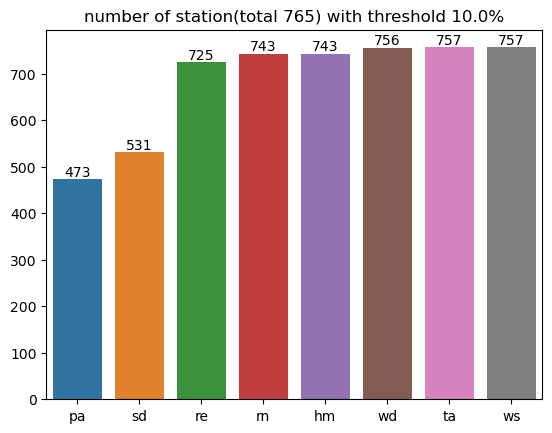

In [90]:
# 값이 있으면서 qcd가 정상인 비율이 10% 이상이라면 관측요소라고 판단.
threshold = 0.1
filtered_using_col = {stn_id: using_col >= threshold for stn_id, using_col in stn_to_is_using_col.items()}
data_col = sum(filtered_using_col.values()).sort_values()
bar = sns.barplot(x=data_col.index, y=data_col)
bar.set_title(f'number of station(total {len(stn_to_is_using_col)}) with threshold {threshold * 100}%')
bar.bar_label(bar.containers[0])

plt.show()

pa와 sd는 측정하지 않는 곳이 많다.

그 외의 나머지 기상요소는 대부분의 관측소가 측정한다고 판단할 수 있다.

('ta', 'wd', 'ws', 'rn', 'pa', 're', 'sd', 'hm') 384
('ta', 'wd', 'ws', 'rn', 're', 'sd', 'hm') 135
('ta', 'wd', 'ws', 'rn', 're', 'hm') 128
('ta', 'wd', 'ws', 'rn', 'pa', 're', 'hm') 60
('ta', 'wd', 'ws', 'rn', 'pa', 'hm') 17
('ta', 'wd', 'ws', 'rn', 're') 9
('ta', 'wd', 'ws', 'pa', 'hm') 9
('ta', 'wd', 'ws', 'hm') 6
('sd',) 5
('ta', 'wd', 'ws', 'rn', 'pa', 're', 'sd') 3
('ta', 'wd', 'ws', 'rn', 're', 'sd') 2
('ta', 'ws', 'rn', 're', 'hm') 2
() 1
('ta', 'wd', 'ws', 'rn', 'hm') 1
('ta', 'wd', 'hm') 1
('wd', 'ws', 'rn', 're', 'sd') 1
('rn', 're', 'sd') 1


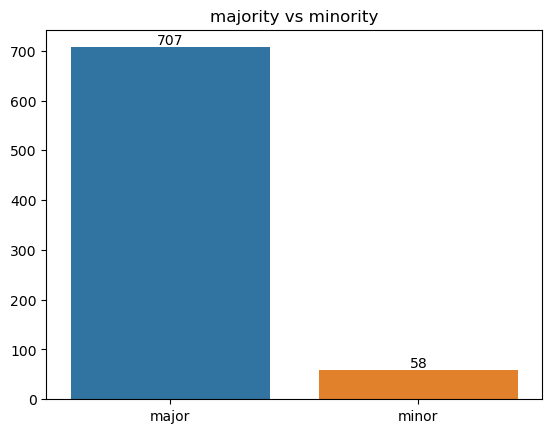

In [58]:
using_cols_to_stn = defaultdict(list)
for stn_id, using_col in filtered_using_col.items():
    using_cols_to_stn[tuple(using_col[using_col].index)].append(stn_id)

using_cols_to_len_stn = sorted([(cols, len(stns)) for cols, stns in using_cols_to_stn.items()], key=lambda x: -x[1])

# pa와 sd 기상요소를 제거하더라도 많은 관측소들이 남는다.
vis = {'major': 0, 'minor': 0}
cols_without_pa_sd = ['ta', 'wd', 'ws', 'rn', 're', 'hm']
for cols, len_stn in using_cols_to_len_stn:
    if set(cols) & set(cols_without_pa_sd) == set(cols_without_pa_sd):
        vis['major'] += len_stn
    else:
        vis['minor'] += len_stn
    print(cols, len_stn)

bar = sns.barplot(x=list(vis.keys()), y=list(vis.values()))
bar.set_title(f'majority vs minority')
bar.bar_label(bar.containers[0])

plt.show()

pa와 sd를 제거하더라도 많은 관측소들의 데이터가 보존되므로 minor는 사용하지 않을 것이다.

In [86]:
val_pc_df = pd.DataFrame([], columns=header_name[1:])
for stn_id, cols_count in stn_to_count_notnull_by_col.items():
    val_pc_df.loc[stn_id] = cols_count[cols_count.index[:-1]] / cols_count['total'] * 100
val_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,99.007431,99.090266,99.092699,97.037647,56.362901,94.576485,52.446776,92.336368
std,9.608234,9.384367,9.384623,16.814387,47.320244,22.429976,40.157147,21.600792
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.998952,99.999427,99.999904,99.999809,0.000000,99.999714,0.000000,99.914806
50%,100.000000,100.000000,100.000000,100.000000,99.403005,100.000000,60.140684,99.998858
75%,100.000000,100.000000,100.000000,100.000000,99.999810,100.000000,99.992005,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


[]

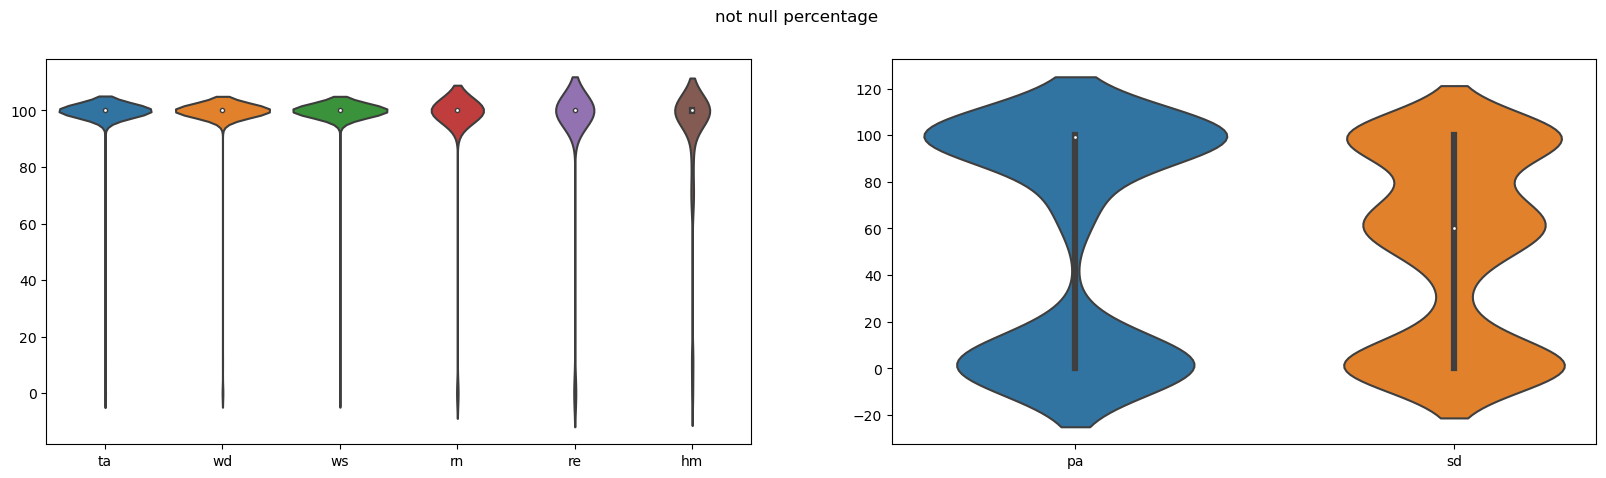

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('not null percentage')
sns.violinplot(val_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[0])
sns.violinplot(val_pc_df[['pa', 'sd']], ax=axes[1])

In [87]:
qcd_norm_pc_df = pd.DataFrame([], columns=header_name[1:])
qcd_anorm_pc_df = pd.DataFrame([], columns=header_name[1:])

for (stn_id, qcd0_cols_count), (_, qcdnan_cols_count), (_, qcd1_cols_count) in zip(stn_to_count_qcd0_by_col.items(), stn_to_count_qcdnan_by_col.items(), stn_to_count_qcd1_by_col.items()):
    qcd_norm_pc_df.loc[stn_id] = qcd0_cols_count / (qcd0_cols_count + qcdnan_cols_count + qcd1_cols_count) * 100
    qcd_anorm_pc_df.loc[stn_id] = qcd1_cols_count / (qcd0_cols_count + qcdnan_cols_count + qcd1_cols_count) * 100

qcd_norm_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,85.842492,85.392887,85.414706,83.201910,51.683990,81.059929,47.204682,80.017865
std,13.871170,14.705386,14.558100,17.960178,43.972781,22.140101,35.979324,21.159081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77.848854,77.798024,77.771441,77.292493,0.000000,77.459953,0.000000,77.632958
50%,79.508608,79.042880,79.093493,77.960860,74.206049,77.949799,56.552843,77.953583
75%,99.264755,99.139751,99.097458,98.044878,99.199762,98.621882,77.730422,99.180219
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [88]:
qcd_anorm_pc_df.describe()

,ta,wd,ws,rn,pa,re,sd,hm
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,1.137080,1.583083,1.560959,3.935252,43.783344,6.202072,48.000161,7.789131
std,9.643656,10.735978,10.547426,16.702283,47.294446,22.391509,39.874965,21.603516
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003905,0.008417,0.015431,0.311852,0.010479,0.080324,1.894028,0.006193
50%,0.010956,0.054416,0.076959,0.659039,1.739703,0.270582,41.208006,0.017065
75%,0.034074,0.210369,0.274837,1.293992,100.000000,0.826100,100.000000,0.241127
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


<Axes: >

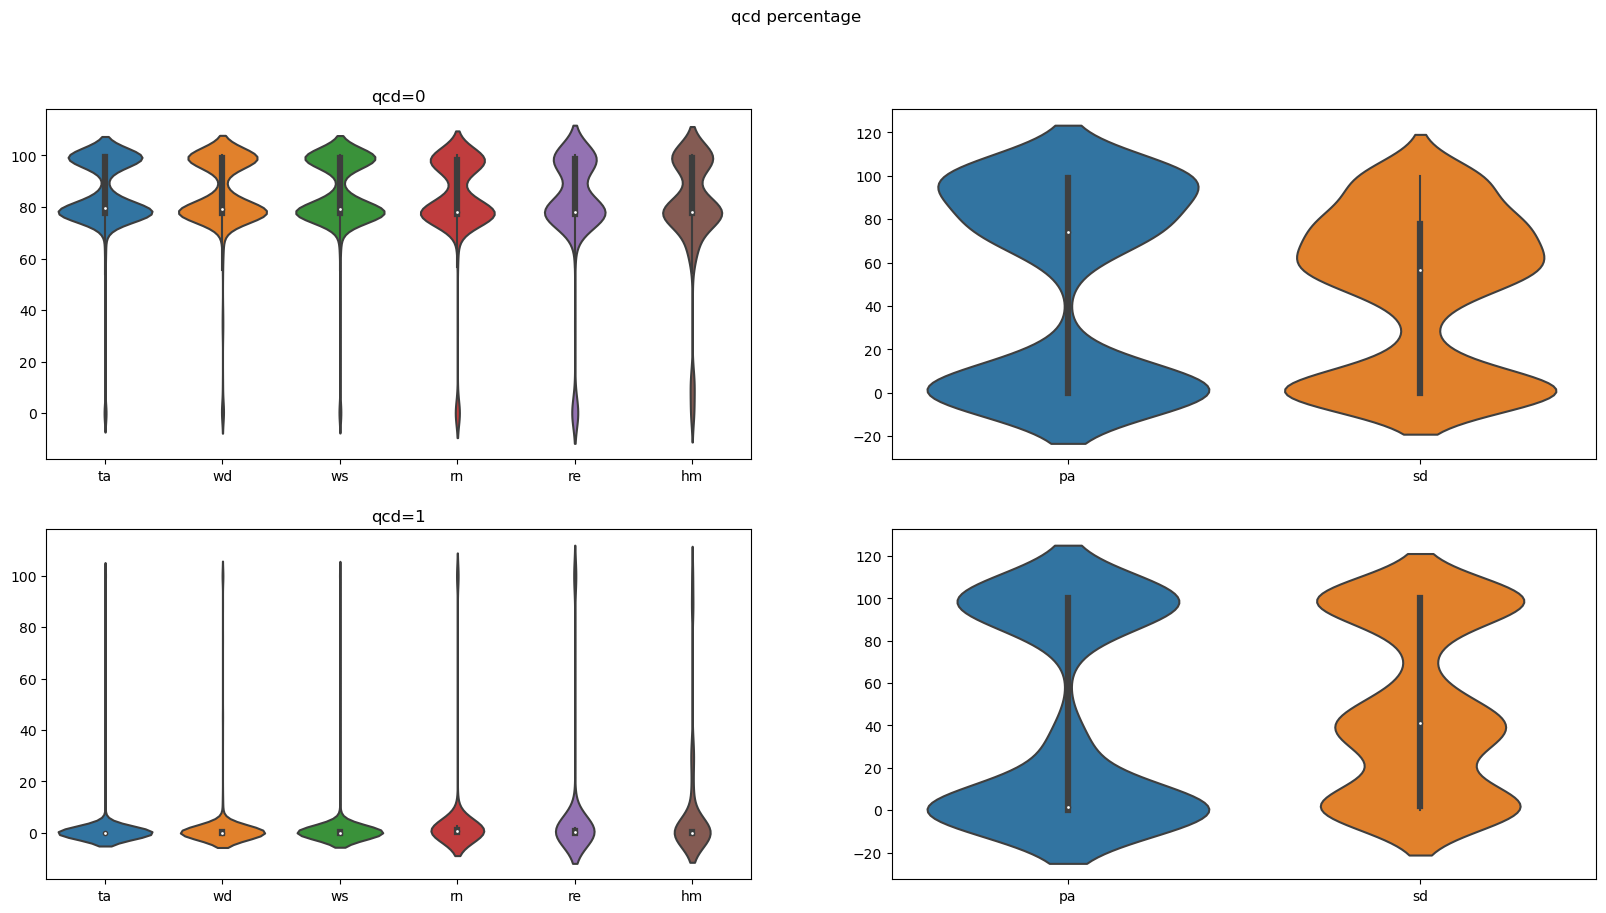

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('qcd percentage')
axes[0][0].set_title('qcd=0')
axes[1][0].set_title('qcd=1')
sns.violinplot(qcd_norm_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[0][0])
sns.violinplot(qcd_norm_pc_df[['pa', 'sd']], ax=axes[0][1])
sns.violinplot(qcd_anorm_pc_df[['ta', 'wd', 'ws', 'rn', 're', 'hm']], ax=axes[1][0])
sns.violinplot(qcd_anorm_pc_df[['pa', 'sd']], ax=axes[1][1])


관측소별 그래프 그리기

In [127]:
# stn_id를 가지고 그래프를 그림
# 파란바탕과 빨간바탕은 qcd의 정상유무이며
# 빨간선은 linear interpolation한 결과이다.
def draw_graph(stn_id, year=None, month=None, min_df=None, qcd_df=None, data_dir='CSV3DB'):
    fig, axes = plt.subplots(4, 2, figsize=(30, 20))

    if min_df and qcd_df:
        pass
    else:
        if year and month:
            min_df, qcd_df = get_min_qcd_df_with_id_year_month(stn_id, year, month)
            fig.suptitle(f'{stn_id:03d}_{year}{month:02d}')
        else:
            min_df, qcd_df = get_min_qcd_df_with_id(stn_id)
            fig.suptitle(f'{stn_id:03d}')
        inappropriate_to_nan(min_df, qcd_df)
        having_full_date(min_df, qcd_df)
        transform_wind_time(min_df, qcd_df)
    
    intp_df = min_df[qcd_df != 1].copy()
    linear_intp_df = intp_df.interpolate(method='time')
    linear_intp_df[['ta', 'wd_x', 'wd_y', 'rn', 'pa', 'sd', 'hm']] = intp_df[['ta', 'wd_x', 'wd_y', 'rn', 'pa', 'sd', 'hm']].interpolate()
    linear_intp_df['re'] = linear_intp_df['re'].interpolate(method='nearest')

    drawing_linear_intp_df = linear_intp_df.copy()
    drawing_linear_intp_df[(qcd_df == 0) & (min_df.notnull())] = np.nan

    for idx, col in enumerate(min_df.columns[:8]):
        axes[idx // 2][idx % 2].set_title(col)
        axes[idx // 2][idx % 2].set_xlim(min_df.index[0], min_df.index[-1])
        # axes[idx // 2][idx % 2].set_xlim(datetime(2021, 4, 2, 15, 30), datetime(2021, 4, 2, 16, 35))
        axes[idx // 2][idx % 2].tick_params('x', labelsize=7)

        axes[idx // 2][idx % 2].plot(min_df[col], linewidth=0.5)
        axes[idx // 2][idx % 2].plot(drawing_linear_intp_df[col], color='r', linewidth=0.5)

        # qcd 정상에 대해 파란바탕
        normal_stack = list()
        for qcd_time in qcd_df[col][qcd_df[col] == 0].index:
            start_t, end_t = qcd_time - timedelta(seconds=30), qcd_time + timedelta(seconds=30)
            if normal_stack and normal_stack[-1][1] == start_t:
                start_t = normal_stack.pop()[0]
            normal_stack.append((start_t, end_t))
        for start_t, end_t in normal_stack:
            axes[idx // 2][idx % 2].axvspan(start_t, end_t, facecolor='b', alpha=0.3)

        # qcd 비정상에 대해 빨간바탕
        abnormal_stack = list()
        for qcd_time in qcd_df[col][qcd_df[col] > 0].index:
            start_t, end_t = qcd_time - timedelta(seconds=30), qcd_time + timedelta(seconds=30)
            if abnormal_stack and abnormal_stack[-1][1] == start_t:
                start_t = abnormal_stack.pop()[0]
            abnormal_stack.append((start_t, end_t))
        for start_t, end_t in abnormal_stack:
            axes[idx // 2][idx % 2].axvspan(start_t, end_t, facecolor='r', alpha=0.3)

    plt.show()

    

# 값이없는곳이거나
# 빨간곳 그리기

# 값이 있는곳 그리고 빨간색아닌곳 없애기
# 21/12/163
# 21/03/361
# 21/04/368

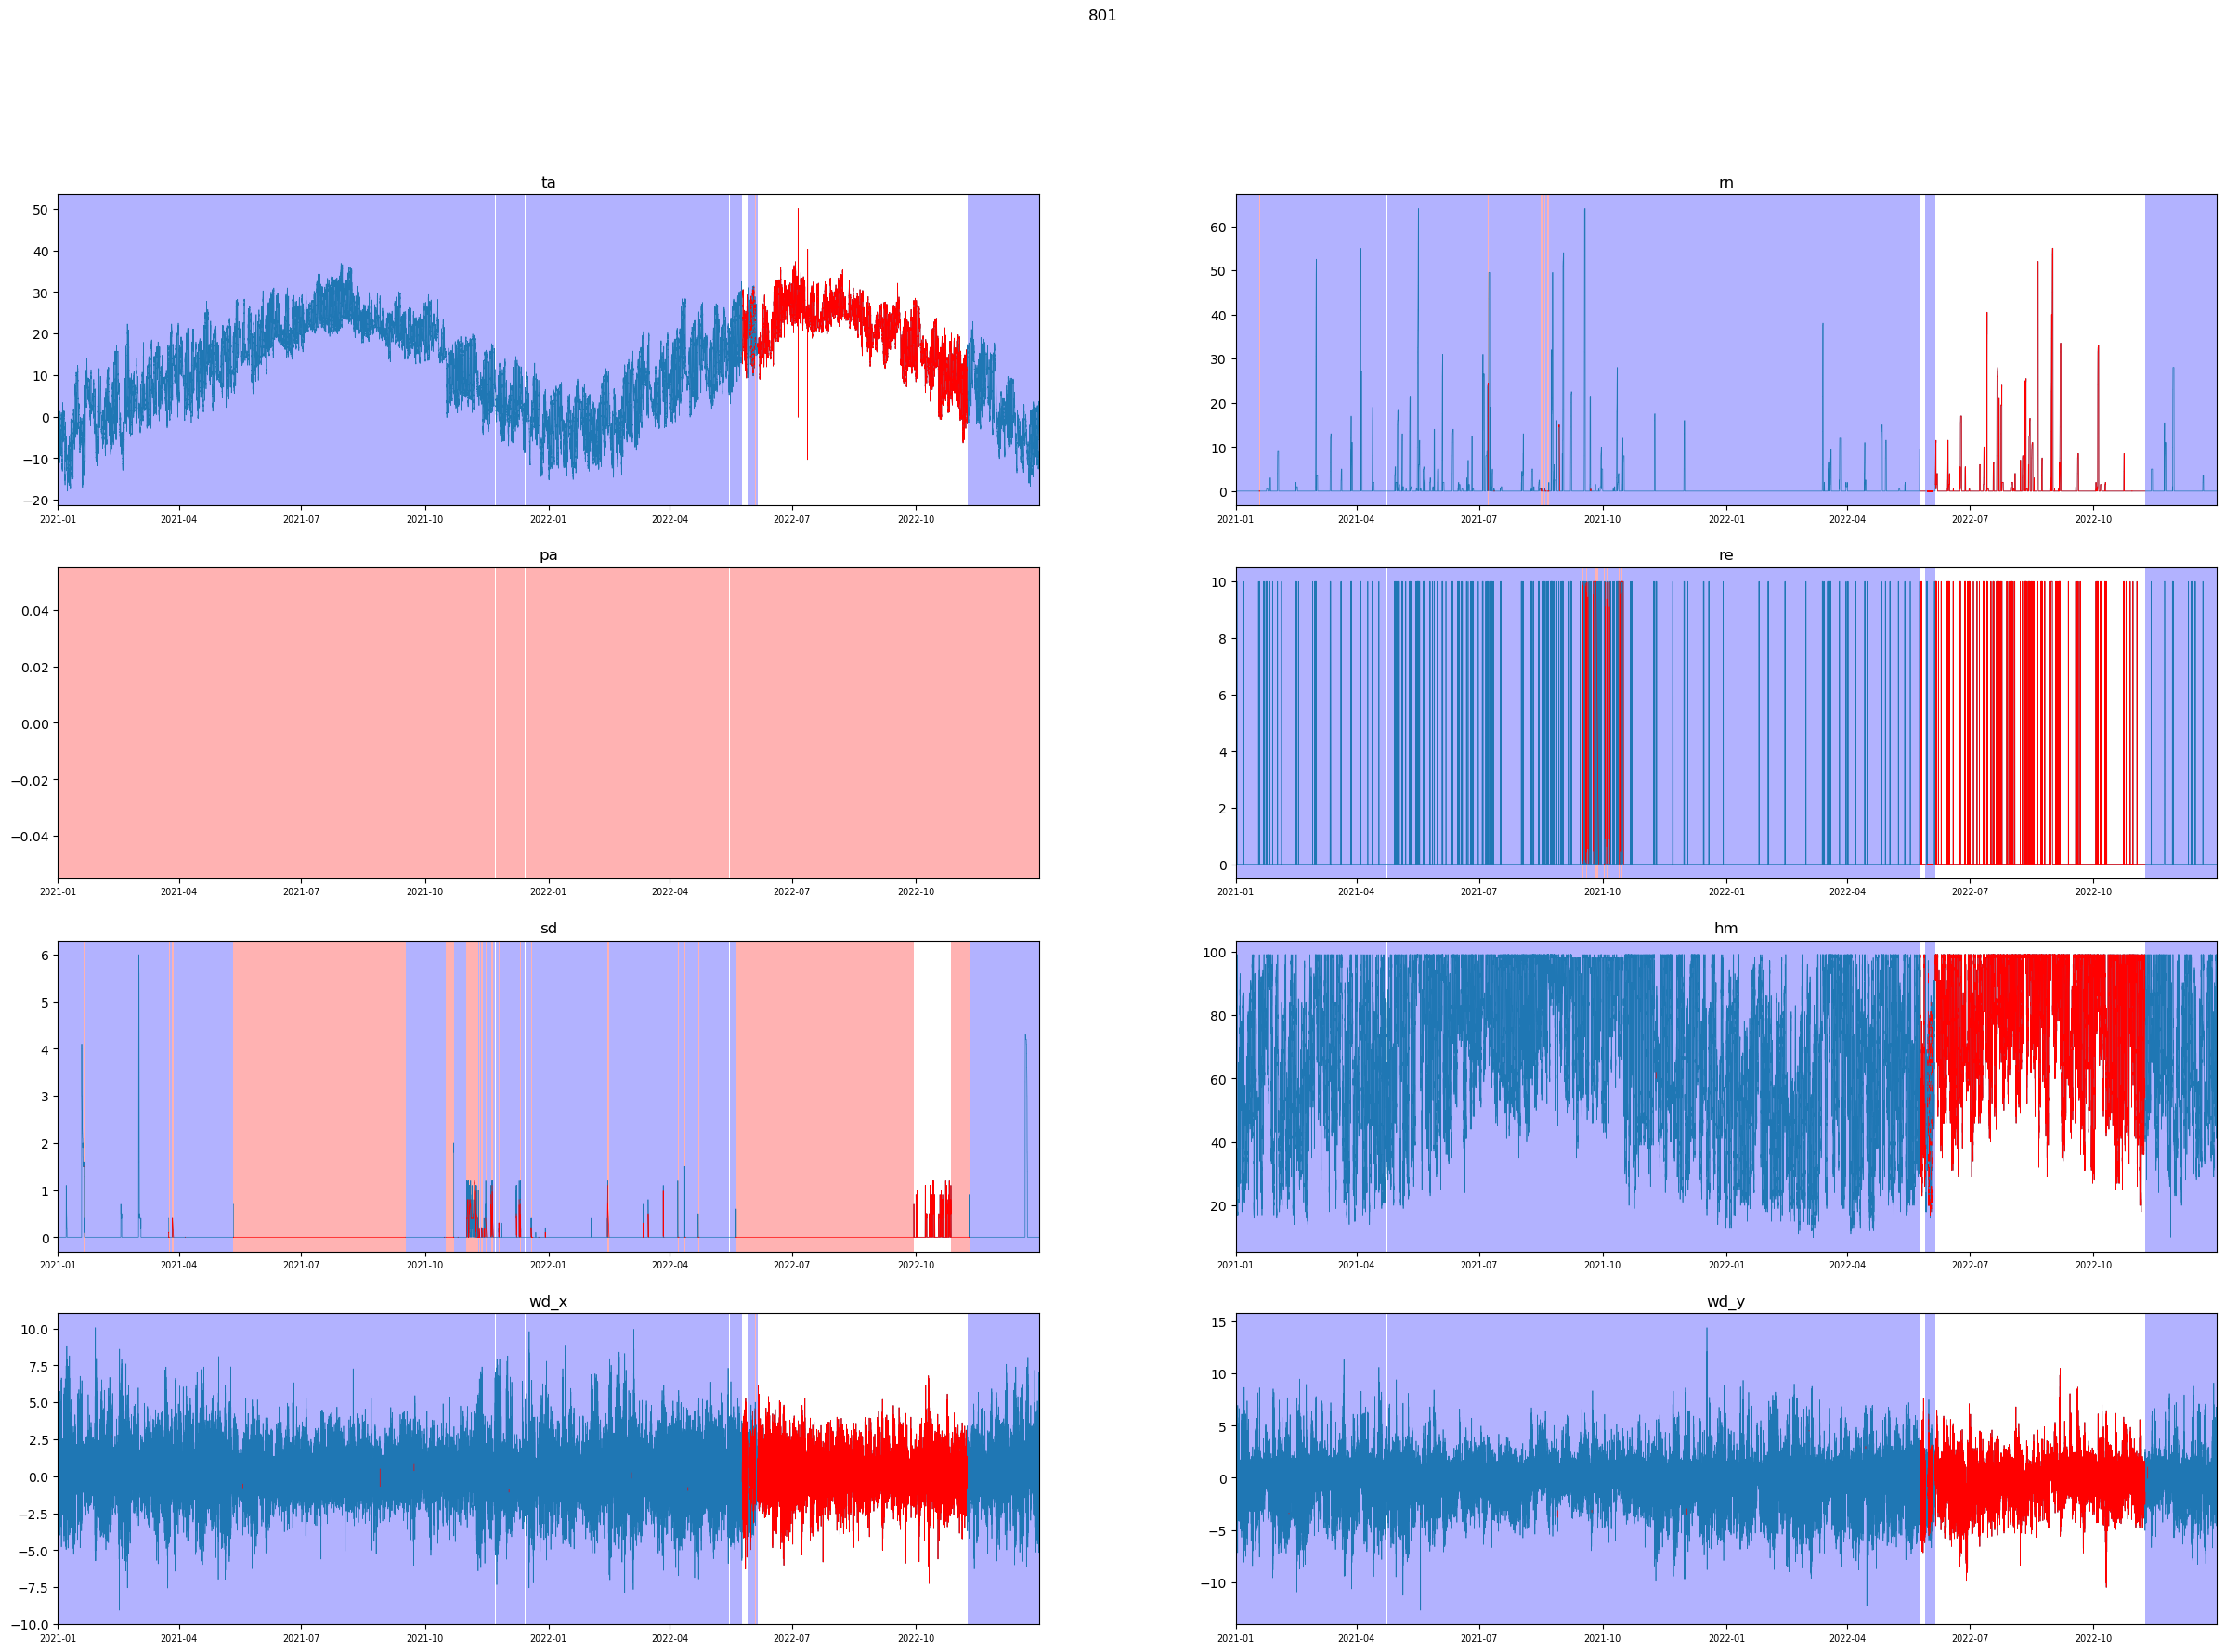

In [128]:
# pick_year = 2022
# pick_stn_id = 509
# pick_month = 10

pick_year = 2022
pick_stn_id = np.random.choice(list(getattr(dlqc, f'min_{pick_year}')))
pick_month = np.random.choice(np.where(getattr(dlqc, f'min_{pick_year}')[pick_stn_id])[0]) + 1

# draw_graph(stn_id=pick_stn_id, year=pick_year, month=pick_month)
draw_graph(stn_id=pick_stn_id)


## 전처리를 위한 csv 내용을 담는 클래스 정의

여기서 전처리 작업을 진행하는데, 전처리 전략은 다음과 같다.

1. -999와 같은 값은 결측값이라고 판단

2. 각 column당 nan의 비율이 90% 이상이거나 qcd 90% 이상이 1이라면 해당 column은 측정하지 않는 기상요소라고 판단, 사용하지 않을 것이다.

3. wd, ws는 모델이 예측하기 어려운 형태이므로 벡터로 변환, wd_x, wd_y로 변환하여 사용한다.

4. 기상요소 예측 모델은 예측을 잘 해야 하므로 정상값들로만 학습시켜야한다. 즉, 결측치, 이상치를 허용해선 안된다.

    따라서 intp_df라는 DataFrame은 결측치, 이상치를 모두 nan으로 처리한뒤 re를 제외한 나머지 기상요소들은 linear interpolation을 이용해 그럴듯한 값으로 채워넣는다.

    re 기상요소는 0과 10만 갖는 값이므로 nearest interpolation을 이용한다.




In [ ]:
# 해당 연도의 csv파일을 읽어 dataframe으로 저장
class all_dfs():
    def __init__(self, dlqc: DLQC, year):
        self.min_dfs = dict()
        self.qcd_dfs = dict()

        pbar = tqdm(getattr(dlqc, f'min_{year}'), desc=str(year))
        for stn_id in pbar:
            min_list = getattr(dlqc, f'min_{year}')[stn_id] > 0

            for month_idx in np.where(min_list)[0]:
                min_df, qcd_df = get_min_qcd_df_with_fulldate_nan(year, month_idx+1, stn_id)

                #############
                # 전처리 전략
                #############
                # 1. min의 -900보다 작은 값은 결측값으로 판단, nan처리
                # 같은 시간대의 qcd에도 1로 지정한다.
                # 가져오는 함수에서 시행됨

                # 2.각 column당 nan이 90% 이상이거나 qcd가 1인 비율이 90%이상이거나 qcd가 0인 비율이 10%이하라면 
                # 해당 column을 측정하지 않는것으로 판단, 모든 값을 결측값 처리해 nan으로한다.
                # 그리고 그 column의 모든 qcd를 1로한다.
                bad_col = (min_df.isnull().sum() / len(min_df) >= 0.9) | ((qcd_df == 1).sum() / len(qcd_df) >= 0.9) | ((qcd_df == 0).sum() / len(qcd_df) <= 0.1)
                bad_col = bad_col[bad_col].index
                min_df[bad_col] = np.nan
                qcd_df[bad_col] = 1


                # 4. wd, ws를 wd_x, wd_y로 변환하여 사용
                # qcd는 1, nan, 0 순으로 적용되며 
                # wd, ws중 하나라도 값이 있다면 wd_x, wd_y에 둘 다 적용한다.
                wd_rad = min_df.wd * np.pi / 180

                min_df['wd_x'] = min_df['ws'] * np.sin(wd_rad)
                min_df['wd_y'] = min_df['ws'] * np.cos(wd_rad)
                min_df.drop(columns=['wd', 'ws'], inplace=True)

                qcd_df.loc[((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = 1
                # nan이 있으면 +연산이 되지 않아 nan값을 갖는다.
                qcd_df.loc[~((qcd_df['wd'] > 0) | (qcd_df['ws'] > 0)), ['wd_x', 'wd_y']] = qcd_df['wd'] + qcd_df['ws']
                qcd_df.drop(columns=['wd', 'ws'], inplace=True)


                # 이외 나머지 qcd가 1인 값들은 이상치라 본다.

                self.min_dfs[(int(year), month_idx+1, stn_id)] = min_df
                self.qcd_dfs[(int(year), month_idx+1, stn_id)] = qcd_df


    def get_min_qcd_df(self, year, month, stn_id):
        return self.min_dfs[(year, month, stn_id)], self.qcd_dfs[(year, month, stn_id)]
    

    def get_intp_df(self, year, month, stn_id):
        # intp_df는 결측치, 이상치를 허용하면 안되므로 qcd가 1인 부분은 가져오지 않는다.
        intp_df = self.min_dfs[(year, month, stn_id)][self.qcd_dfs[(year, month, stn_id)] != 1].copy()
        intp_df[['ta', 'wd', 'ws', 'rn', 'pa', 'sd', 'hm']] = intp_df[['ta', 'wd', 'ws', 'rn', 'pa', 'sd', 'hm']].interpolate()
        intp_df['re'] = intp_df['re'].interpolate(method='nearest')
        return intp_df
        

In [ ]:
# 데이터 로딩이 느리므로 pickle로 저장, 불러오며 사용
if os.path.isfile(os.path.join(data_dir, 'dfs_2022.pickle')):
    with open(os.path.join(data_dir, 'dfs_2022.pickle'), 'rb') as f:
        dfs_2022 = pickle.load(f)
    print('load pickle')
else:
    dfs_2022 = all_dfs(dlqc, year=2022)
    with open(os.path.join(data_dir, 'dfs_2022.pickle'), 'wb') as f:
        pickle.dump(dfs_2022, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('save pickle')


In [91]:
using_stn_ids_with_qcd = list()
for (stn_id, col1), (_, col2), (_, col3) in zip(stn_to_usecol.items(), stn_to_qcd0.items(), stn_to_qcd1.items()):
    if all(v1 and v2 / (v2+v3) > 0.9 for (c, v1), (_, v2), (_, v3) in zip(col1.items(), col2.items(), col3.items()) if c in ['ta', 'wd', 'ws', 'rn', 're', 'hm']):

        using_stn_ids_with_qcd.append(stn_id)

print(using_stn_ids_with_qcd)


NameError: name 'stn_to_usecol' is not defined

In [ ]:
using_stn_ids = list()
for stn_id, col in stn_to_usecol.items():
    if all(v for c, v in col.items() if c in ['ta', 'wd', 'ws', 'rn', 're', 'hm']):
        using_stn_ids.append(stn_id)

print(using_stn_ids)

In [ ]:
bad_stns = list(set(using_stn_ids) - set(using_stn_ids_with_qcd))
print(bad_stns)

In [ ]:
# 714 509

ta    1043160
wd    1041098
ws    1041011
rn    1025372
pa    1043273
re    1039364
sd    1023544
hm    1043306
dtype: int64
ta      282
wd     2344
ws     2431
rn    18070
pa      169
re     4078
sd    19898
hm      136
dtype: int64


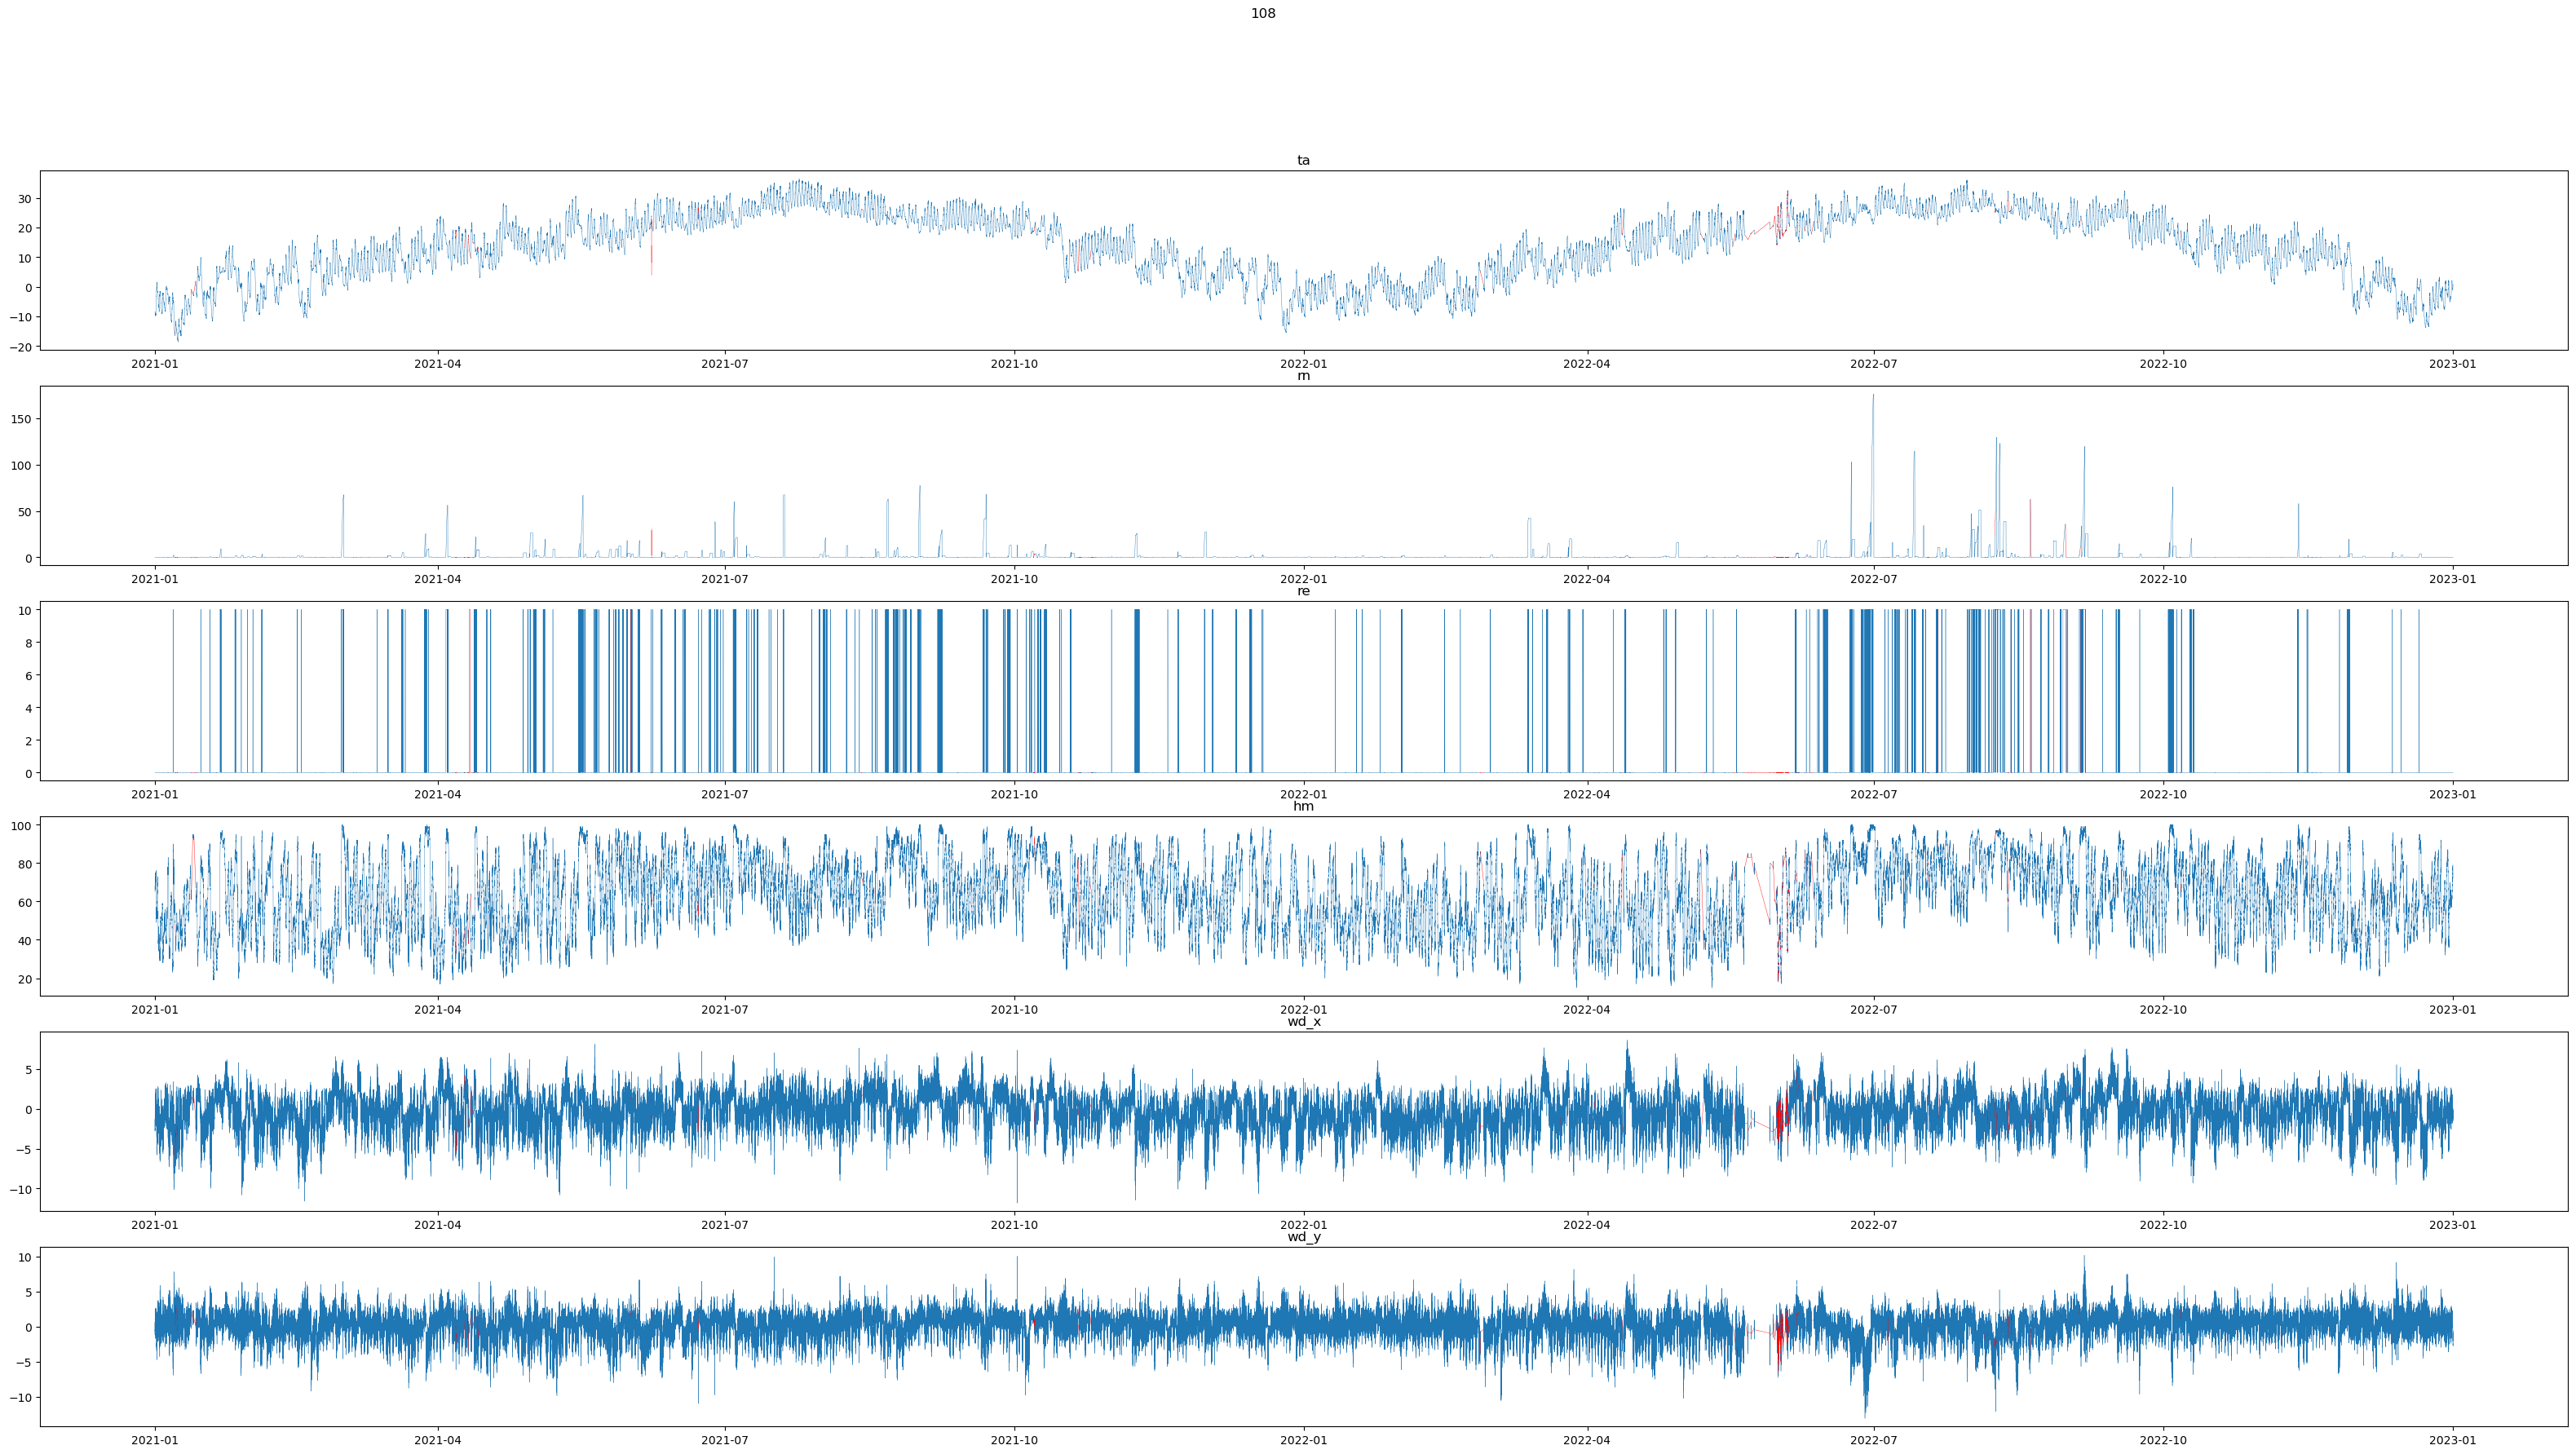

In [95]:
file_list = sorted(os.listdir('CSV3DB/2021/') + os.listdir('CSV3DB/2022/'))

# stn_id = np.random.choice(bad_stns)
stn_id = 108
min_file_list = list(filter(lambda x: x[14:17] == f'{stn_id:03d}' and x[10:13] == 'min', file_list))
cat_df = list()

for csv_name in min_file_list:
    qcd_csv_name = csv_name.replace('min', 'qcd')
    if os.path.isfile(f'CSV3DB/{csv_name[-10:-6]}/{qcd_csv_name}'):
        min_df = pd.read_csv(f'CSV3DB/{csv_name[-10:-6]}/{csv_name}',
                        header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], usecols=[0,1,2,3,4,6,8], index_col=0)
        
        qcd_df = pd.read_csv(f'CSV3DB/{csv_name[-10:-6]}/{qcd_csv_name}',
                        header=None, names=header_name, date_format='%Y.%m.%d %H:%M:%S', parse_dates=[0], usecols=[0,1,2,3,4,6,8], index_col=0)
        
        qcd_df = qcd_df.reindex(min_df.index)
        cat_df.append(min_df[qcd_df == 0].loc[(min_df[qcd_df == 0].isnull().sum(axis=1) == 0) & (min_df[min_df < -900].sum(axis=1) == 0)])

cat_df = pd.concat(cat_df)
wd_rad = cat_df['wd'] * np.pi / 180
cat_df['wd_x'] = cat_df['ws'] * np.sin(wd_rad, dtype=np.float32)
cat_df['wd_y'] = cat_df['ws'] * np.cos(wd_rad, dtype=np.float32)
cat_df.drop(columns=['wd', 'ws'], inplace=True)

time = cat_df.index.view(np.int64)

cat_df['day_sin'] = np.sin(time * (2 * np.pi / 24 * 60 * 60), dtype=np.float32)
cat_df['day_cos'] = np.cos(time * (2 * np.pi / 24 * 60 * 60), dtype=np.float32)
cat_df['year_sin'] = np.sin(time * (2 * np.pi / (365.2425 * 24 * 60 * 60)), dtype=np.float32)
cat_df['year_cos'] = np.cos(time * (2 * np.pi / (365.2425 * 24 * 60 * 60)), dtype=np.float32)



full_cat_df = cat_df.reindex(pd.date_range(cat_df.index[0], cat_df.index[-1], freq='T'))
intp_df = full_cat_df.copy()
intp_df[['ta', 'wd_x', 'wd_y', 'rn', 'hm', 'day_sin', 'day_cos', 'year_sin', 'year_cos']] = intp_df[['ta', 'wd_x', 'wd_y', 'rn', 'hm', 'day_sin', 'day_cos', 'year_sin', 'year_cos']].interpolate()
intp_df['re'] = intp_df['re'].interpolate(method='nearest')
intp_df[full_cat_df.isnull().sum(axis=1) == 0] = np.nan



fig, axes = plt.subplots(6, 1, figsize=(40, 20))
fig.suptitle(stn_id)
for i in range(6):
    axes[i].set_title(full_cat_df.columns[i])
    axes[i].plot(full_cat_df[full_cat_df.columns[i]], lw=0.3)
    axes[i].plot(intp_df[full_cat_df.columns[i]], lw=0.3, color='r')

print(stn_to_count_qcd0_by_col[stn_id])
print(stn_to_count_qcd1_by_col[stn_id])


In [ ]:
full_cat_df

In [ ]:
for time_idx in ((cat_df.isnull().sum(axis=1) == 0).index.to_series().diff() > timedelta(days=30))[((cat_df.isnull().sum(axis=1) == 0).index.to_series().diff() > timedelta(days=30))].index:
    print(cat_df.loc[time_idx])

In [ ]:
temp_stn_id = 750
print(stn_to_qcd0[temp_stn_id])
print(stn_to_qcd1[temp_stn_id])

In [ ]:
stn_to_qcd0[714]

In [ ]:
stn_to_qcd1[714]

In [ ]:
stn_to_qcdnan[714]